In [1]:
# Let's try the DeepLifting MLP on the Bukin function
# we already saw that it had a great solution for the
# Ackley function

In [2]:
import time
import sys

# Append the path for this notebook
sys.path.append("/Users/ryandevera/data-science/umn_environments/Deeplifting")

import matplotlib.pyplot as plt
import numpy as np
import torch
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

from deeplifting.models import DeepliftingMLP

In [3]:
# Let's create the objective
def bukin_n6(x, y):
    return 100.0 * np.sqrt(np.abs(y - 0.01 * x**2)) + 0.01 * np.abs(x + 10.0)


# Check the right value is returned at known local minima
x, y = np.array([-10.0, 1.0])
print(bukin_n6(x, y))

x, y = np.array([-9.99999, 0.99999])
print(bukin_n6(x, y))

0.0
0.28284283015400097


Text(0.5, 0.92, 'Bukin N. 6 Function Surface Plot')

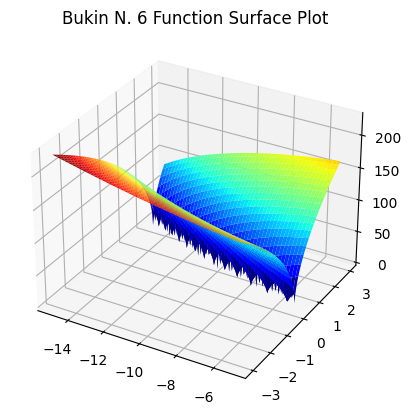

In [4]:
# Plot the Ackley Function in 3D
x_min, x_max = -15, -5
x_axis = np.arange(x_min, x_max, 0.05)

y_min, y_max = -3, 3
y_axis = np.arange(y_min, y_max, 0.05)
x, y = np.meshgrid(x_axis, y_axis)
f = bukin_n6(x, y)

figure = plt.figure()
axis = figure.add_subplot(111, projection="3d")
axis.plot_surface(x, y, f, cmap="jet", shade="false")

# Set the title
axis.set_title("Bukin N. 6 Function Surface Plot")

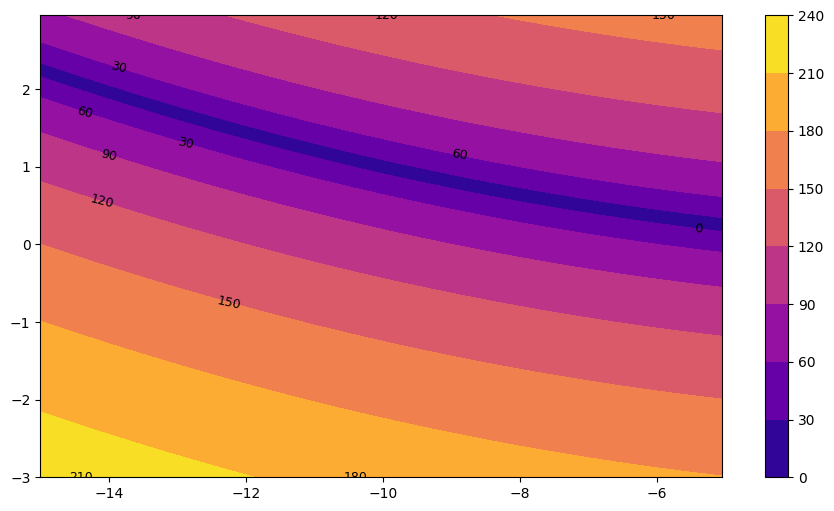

In [5]:
# Let's also view the contours
figure = plt.figure(figsize=(11, 6))
cp = plt.contourf(x, y, f, cmap='plasma')
plt.clabel(cp, inline=True, fontsize=9, colors='black')
plt.colorbar(cp)

In [6]:
# Get the device type
# For now we will just utilize cpu
device = torch.device('cpu')


def bukin_n6(x, y):
    return 100.0 * torch.sqrt(torch.abs(y - 0.01 * x**2)) + 0.01 * torch.abs(x + 10.0)


# Create the combined function
def bukin_fn(model, points):
    """
    Combined function we will take the model as input
    """
    # Remember we are letting the input be
    # variable
    output = model(inputs=None)
    x, y = output

    # Let's try out trick from topology
    # optimization instead of relying on the
    # inequality constraint
    # If we map x and y to [0, 1] and then shift
    # the interval we can accomplist the same
    # thing we can use a + (b - a) * x
    x = torch.sigmoid(x) * (-5 + 15) - 15
    y = torch.sigmoid(y) * (3 + 3) - 3
    # print(x, y)

    # Objective function
    f = bukin_n6(x, y)

    # Inequality constraint
    ci = None

    # equality constraint
    ce = None

    return f, ci, ce


# Define the model
model = DeepliftingMLP(input_size=50, layer_sizes=(128, 256, 256, 128), output_size=2)
model = model.to(device=device, dtype=torch.double)
nvar = getNvarTorch(model.parameters())
print(nvar)

139498


In [7]:
torch.manual_seed(1)
# Setup a pygransoStruct for the algorithm
# options
opts = pygransoStruct()

x0 = (
    torch.nn.utils.parameters_to_vector(model.parameters())
    .detach()
    .reshape(nvar, 1)
    .to(device=device, dtype=torch.double)
)

opts.x0 = x0
opts.torch_device = device
opts.print_frequency = 10
opts.limited_mem_size = 100
opts.stat_l2_model = False
opts.double_precision = True
opts.viol_ineq_tol = 1e-8
opts.opt_tol = 1e-8

points = []
comb_fn = lambda model: bukin_fn(model, points)

# Run the main algorithm
start = time.time()
soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)
end = time.time()

print(f"Starting point for problem = {x0}")
print("\n")
print("Total Wall Time: {}s".format(end - start))
print(soln.final.f)
print("\n")



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

/Users/ryandevera/.virtualenvs/deeplifing/lib/python3.9/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


  10 ║  - │   -   ║  6.25012363993 ║   -  │   -  ║ QN │     1 │ 1.000000 ║     1 │ 0.016086   ║ 
  20 ║  - │   -   ║  0.01070202483 ║   -  │   -  ║ QN │    10 │ 0.005859 ║     1 │ 0.148749   ║ 
  30 ║  - │   -   ║  0.00242042618 ║   -  │   -  ║ QN │    20 │ 5.72e-06 ║     1 │ 0.274808   ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
F = final iterate, B = Best (to tolerance), MF = Most Feasible                                ║ 
Optimization results:                                                                         ║ 
═════╦════════════╦════════════════╦═════════════╦═══════════════════════╦════════════════════╣
   F ║    │       ║  0.00238457419 ║   -  │   -  ║    │       │          ║       │            ║ 
   B ║    │       ║  0.00238352052 ║   -  │   -  ║    │       │          ║       │            ║ 
═════╩════════════╩════════════════╩═════════════╩═══════════════════════╩════════════════════╣
Iterations:              37      

In [8]:
xf, yf = model(inputs=None)
xf = (torch.sigmoid(xf) * 10 - 15).detach()
yf = (torch.sigmoid(yf) * 6 - 3).detach()

print(xf, yf, bukin_n6(xf, yf))

tensor(-9.7616, dtype=torch.float64) tensor(0.9529, dtype=torch.float64) tensor(0.0024, dtype=torch.float64)


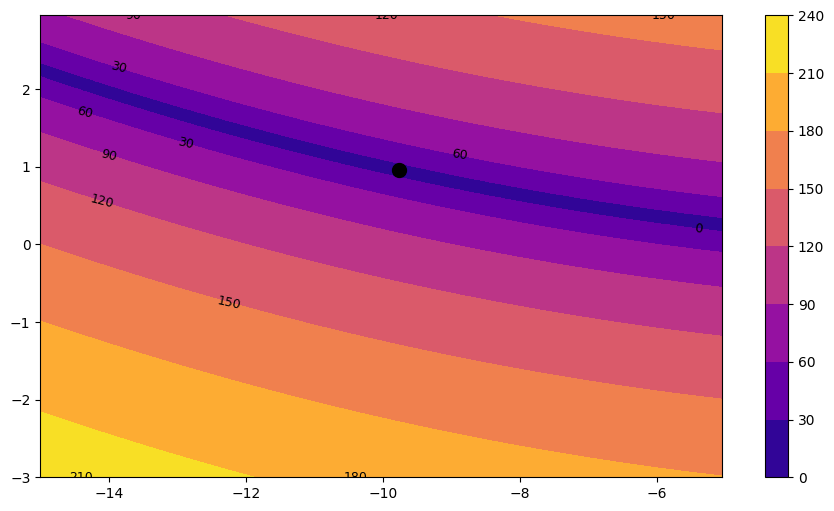

In [9]:
def bukin_n6(x, y):
    return 100.0 * np.sqrt(np.abs(y - 0.01 * x**2)) + 0.01 * np.abs(x + 10.0)


# Plot the Ackley Function in 3D
x_min, x_max = -15, -5
x_axis = np.arange(x_min, x_max, 0.05)

y_min, y_max = -3, 3
y_axis = np.arange(y_min, y_max, 0.05)
x, y = np.meshgrid(x_axis, y_axis)
f = bukin_n6(x, y)

figure = plt.figure(figsize=(11, 6))
cp = plt.contourf(x, y, f, cmap='plasma')
plt.clabel(cp, inline=True, fontsize=9, colors='black')
plt.colorbar(cp)

plt.scatter(float(xf.numpy()), float(yf.numpy()), color='black', marker='o', s=100)